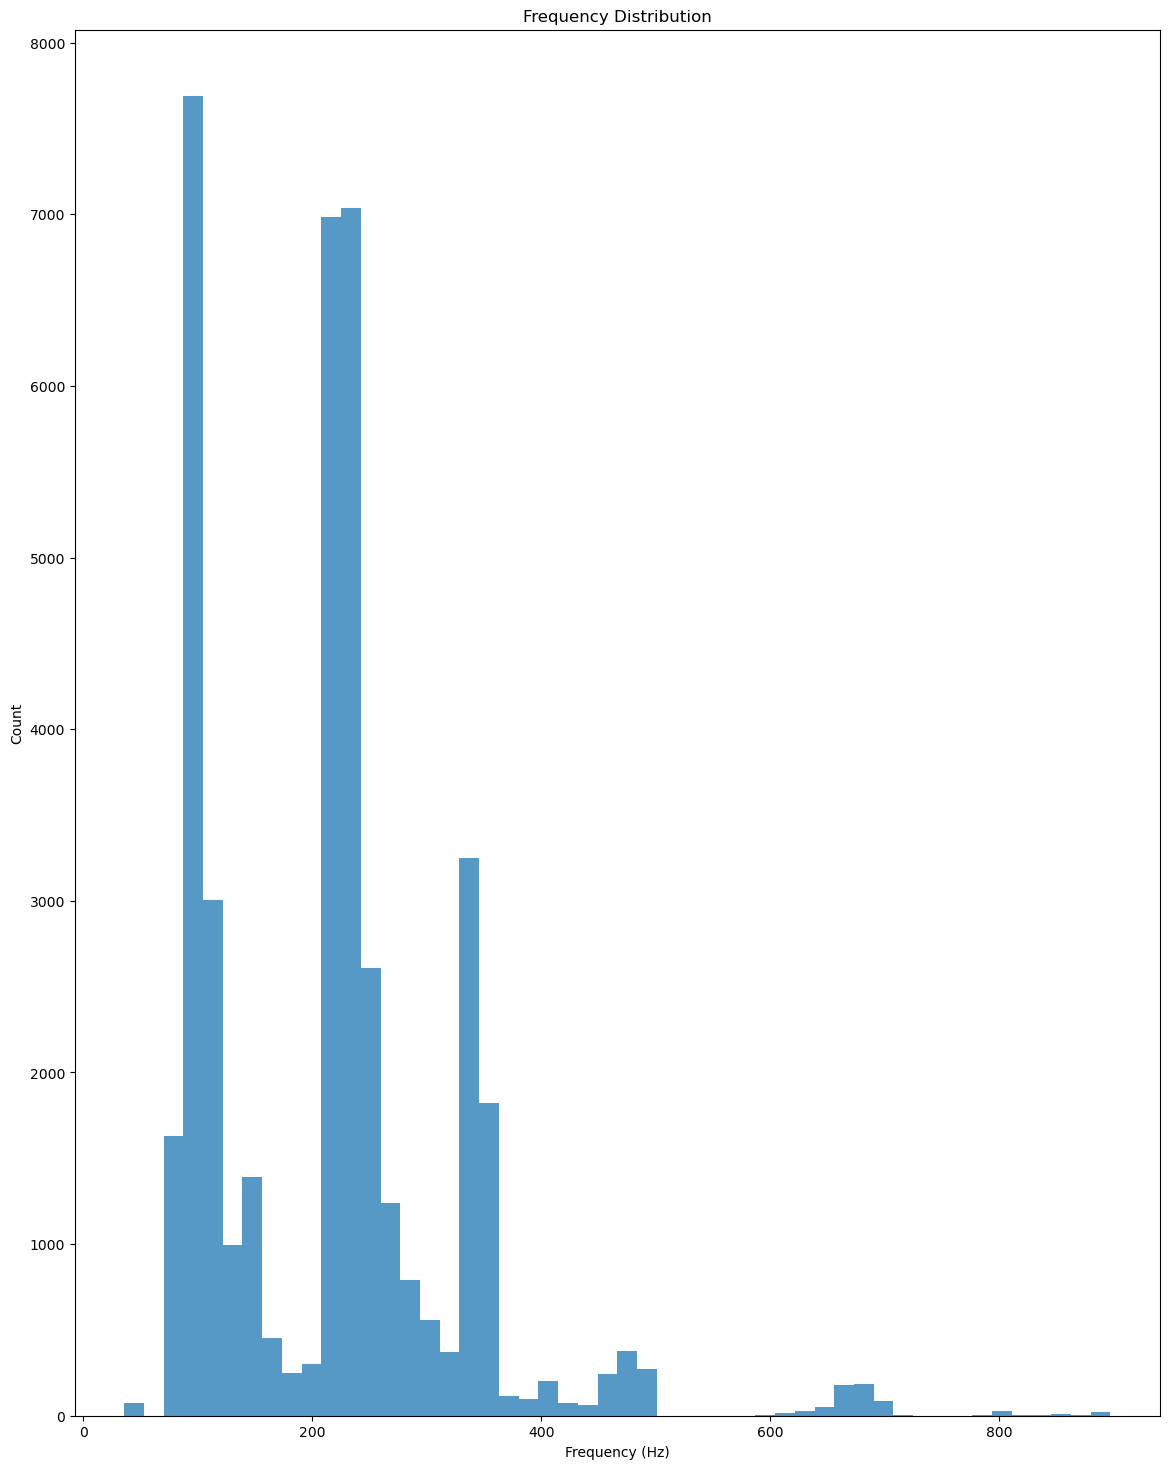

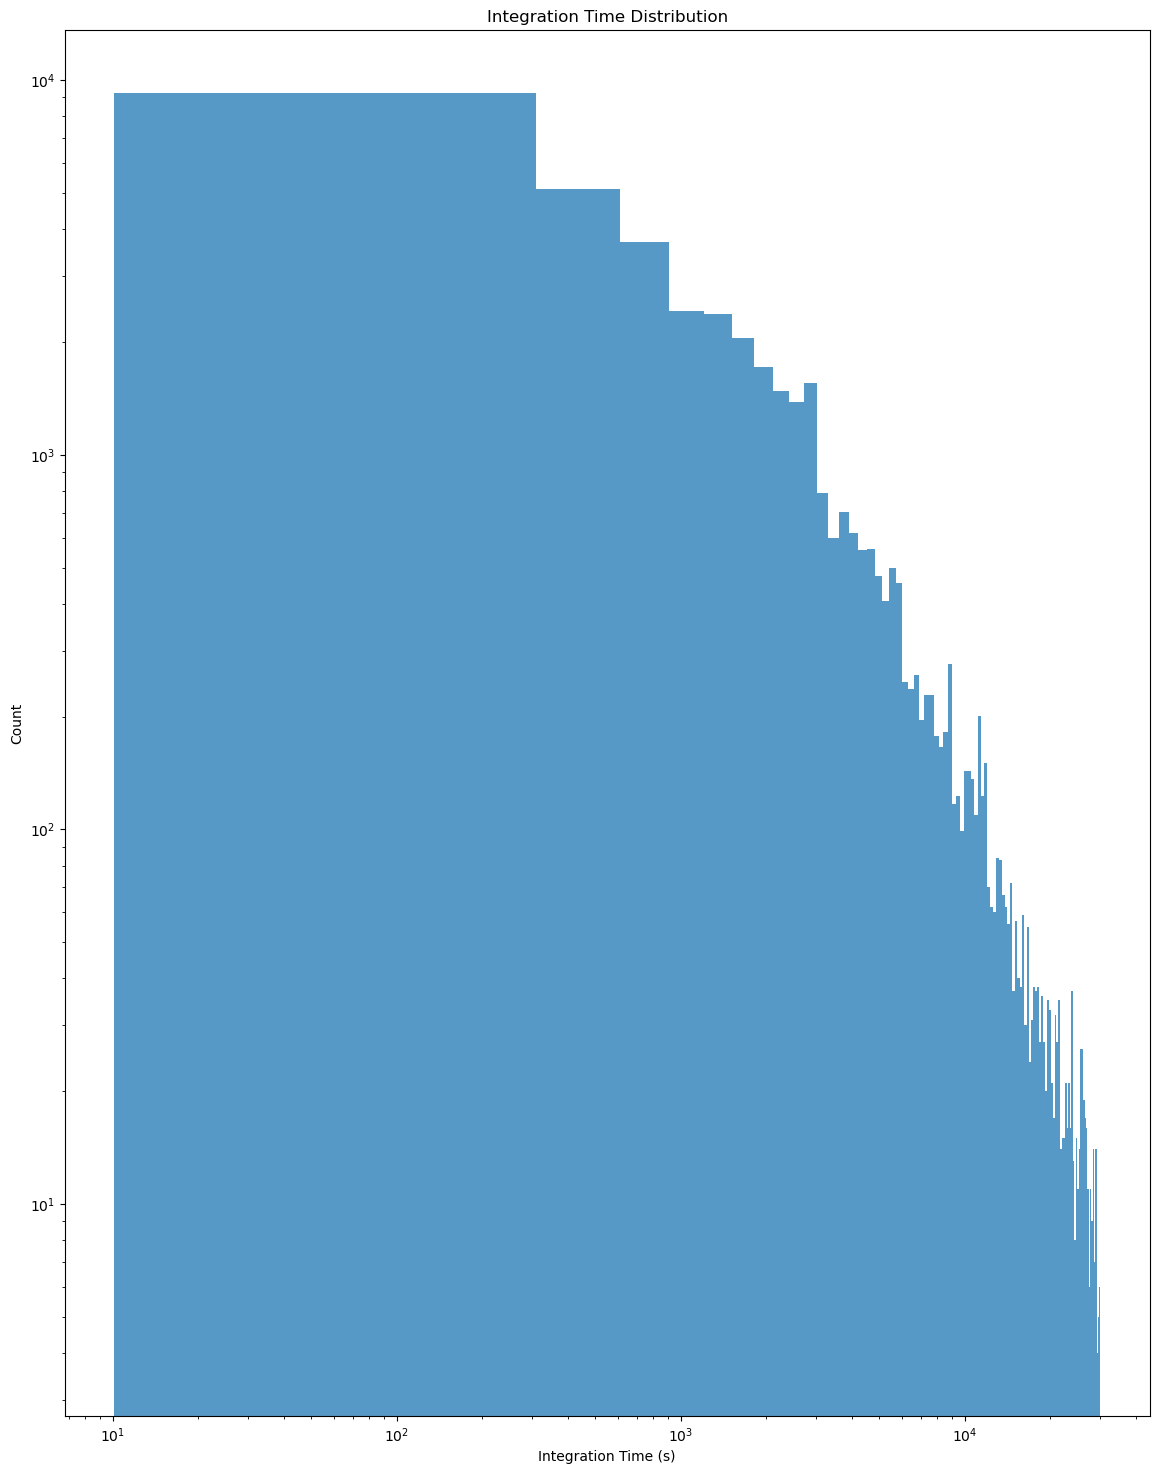

C:\Users\lsann\AppData\Local\Temp\ipykernel_12964\2946792693.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  db_sk_f = db.groupby(['science_keyword', 'frequency_bin']).size().unstack(fill_value=0)
C:\Users\lsann\AppData\Local\Temp\ipykernel_12964\2946792693.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  db_sk_t = db.groupby(['science_keyword', 'time_bin']).size().unstack(fill_value=0)


Counts of Science Keywords with ALMA Bands:
band_list                                            1  10    3    4    5  \
science_keyword                                                             
Active Galactic Nuclei (AGN)/Quasars (QSO)           1   1  694  123   88   
Astrochemistry                                       1   5  344   78   38   
Asymptotic Giant Branch (AGB) stars                  0  11  135   22    1   
Black holes                                          2   0   52   18    0   
Brown dwarfs                                         0   0   12    0    0   
Cataclysmic stars                                    0   0    1    2    0   
Cosmic Microwave Background (CMB)/Sunyaev-Zel'd...   5   0   61   20    0   
Damped Lyman Alpha (DLA) systems                     0   0   40   32    6   
Debris disks                                         0   1   10    4   10   
Disks around high-mass stars                         0   1   14   16    1   
Disks around low-mass stars     

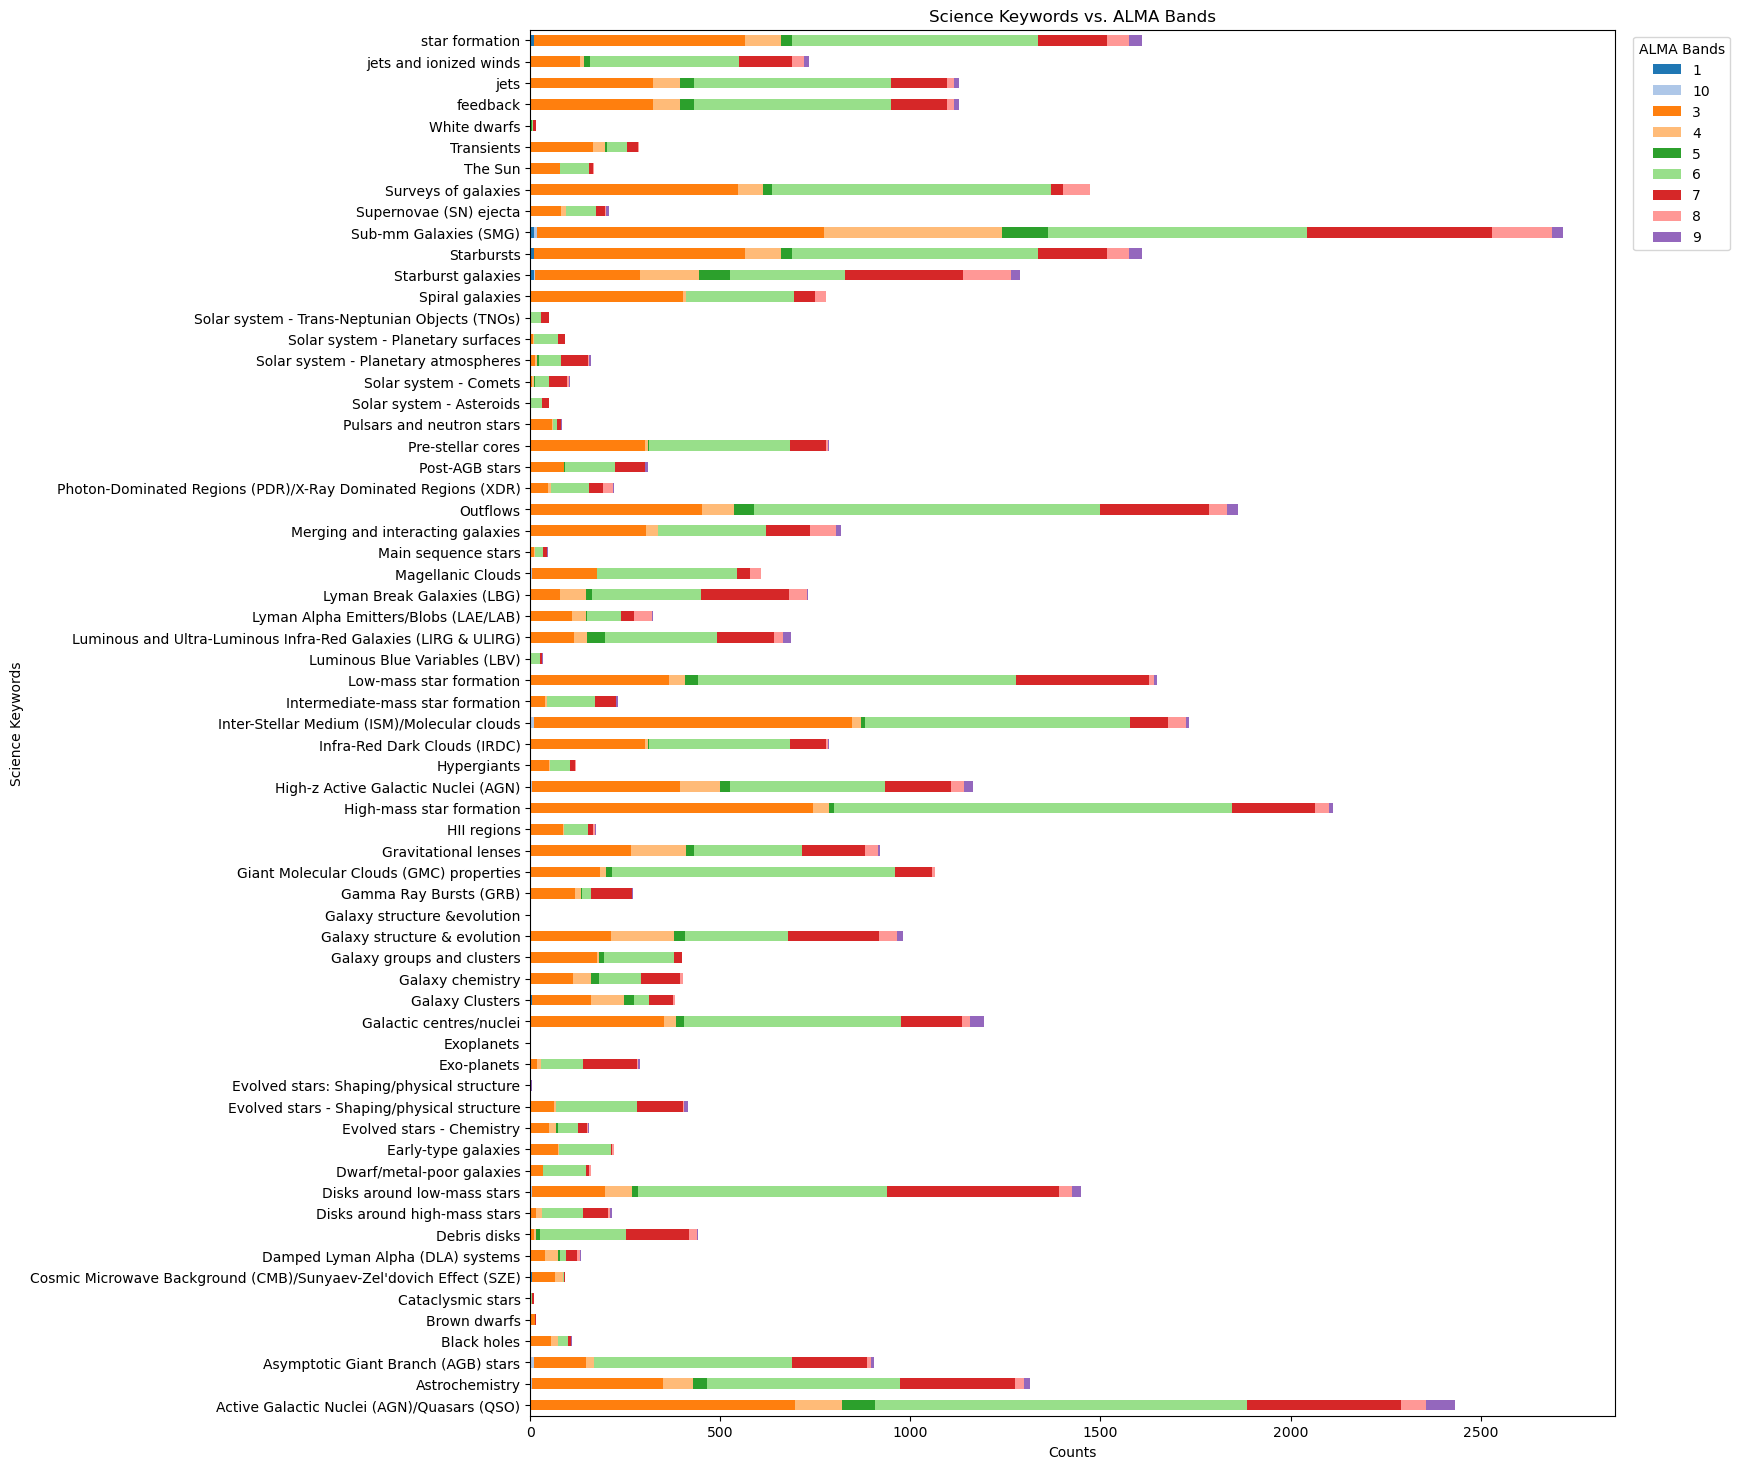

Counts of Science Keywords with Integration Time:
time_bin                                            (10.08, 1010.08]  \
science_keyword                                                        
Active Galactic Nuclei (AGN)/Quasars (QSO)                      1183   
Astrochemistry                                                   352   
Asymptotic Giant Branch (AGB) stars                              588   
Black holes                                                       60   
Brown dwarfs                                                       3   
Cataclysmic stars                                                  3   
Cosmic Microwave Background (CMB)/Sunyaev-Zel'd...                 8   
Damped Lyman Alpha (DLA) systems                                  19   
Debris disks                                                      94   
Disks around high-mass stars                                      83   
Disks around low-mass stars                                      536   
Dwarf/metal-po

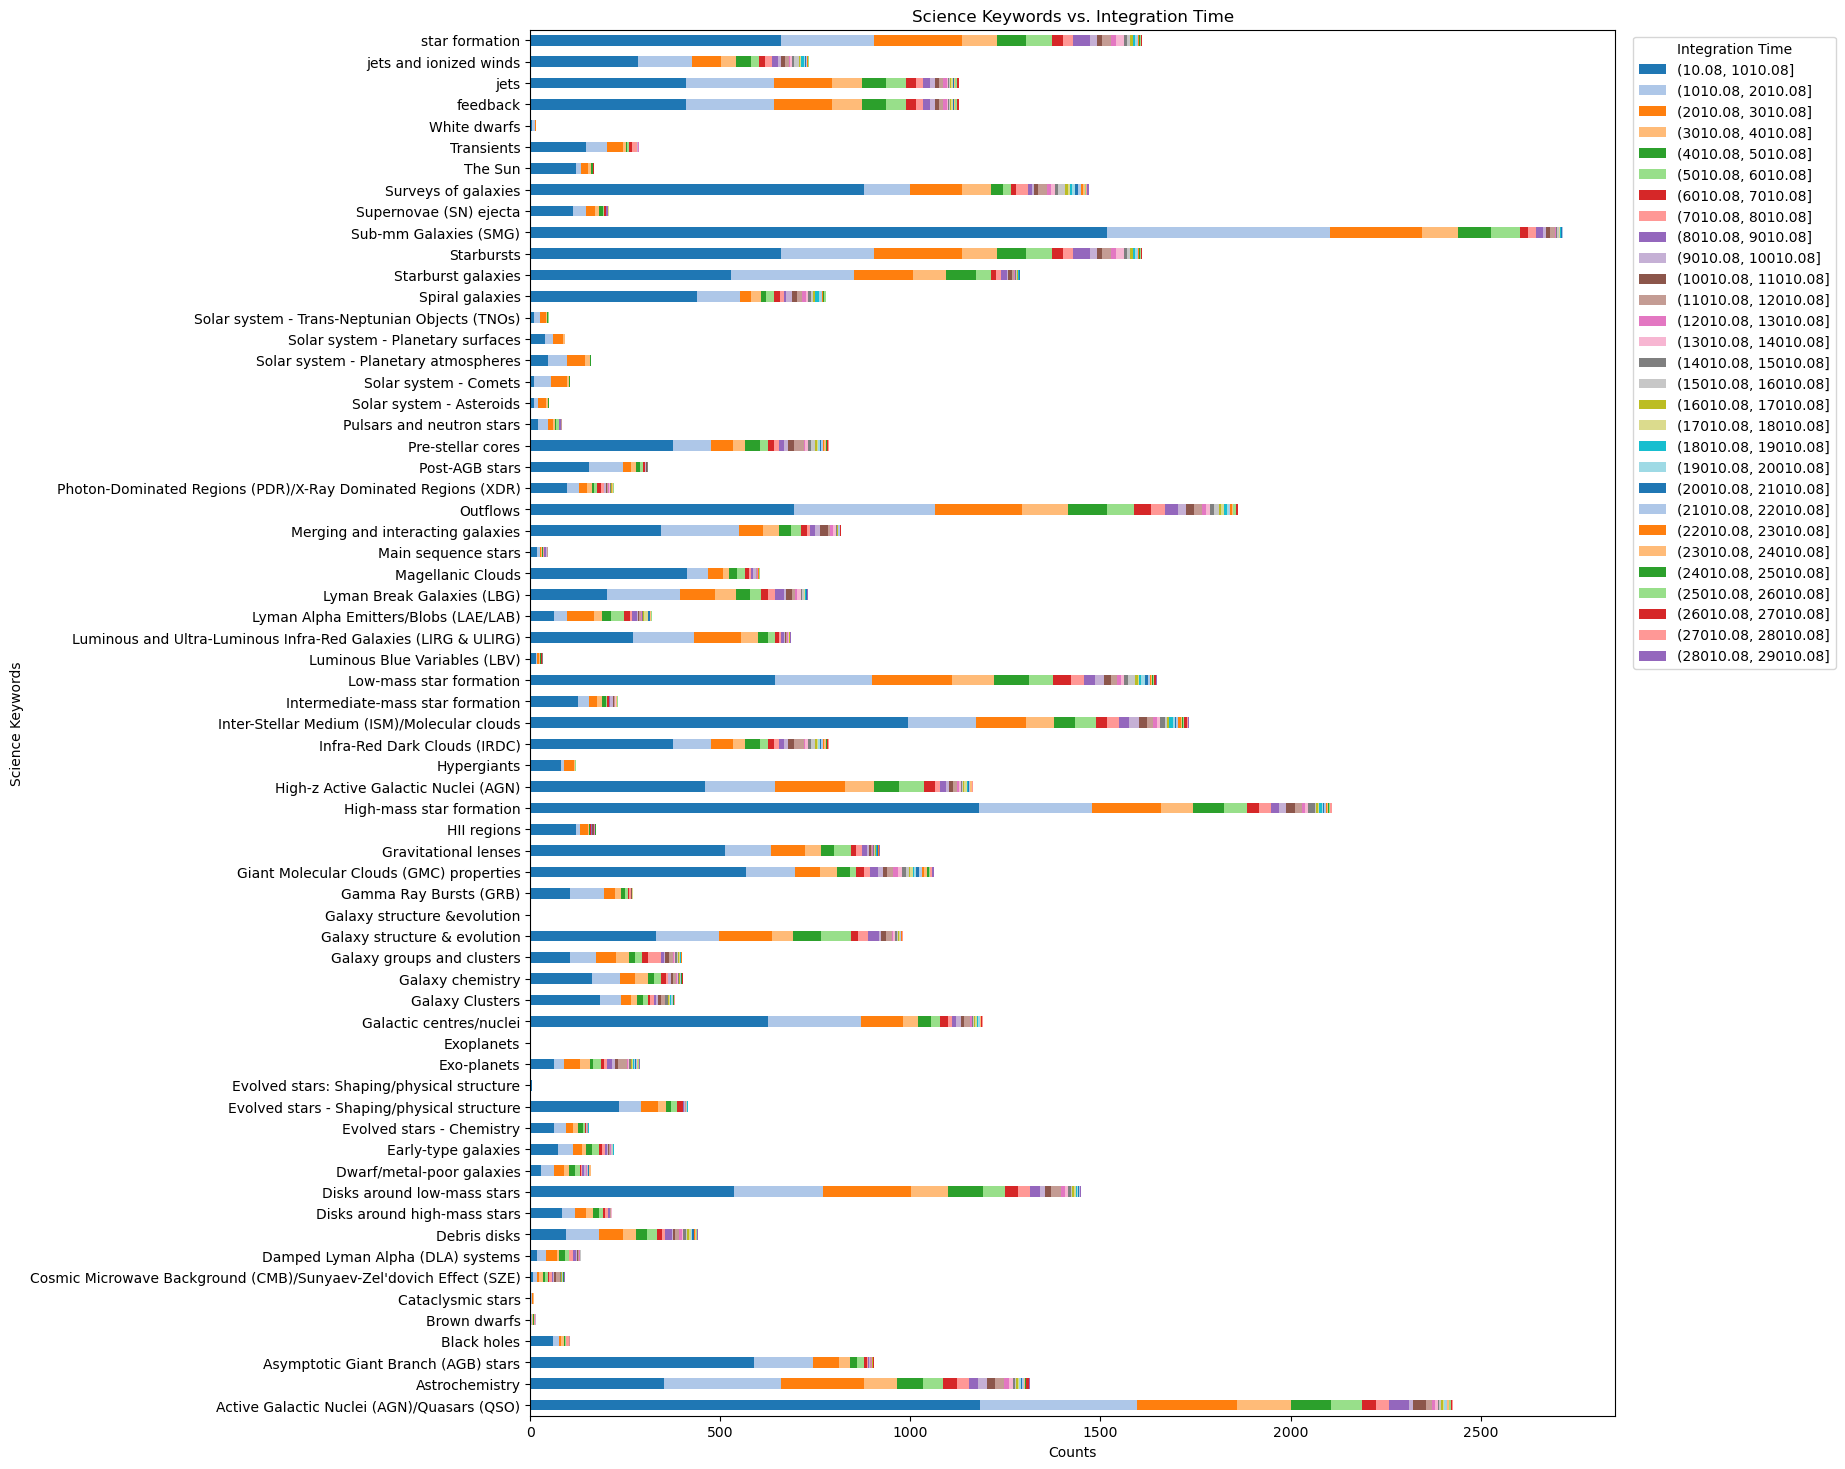

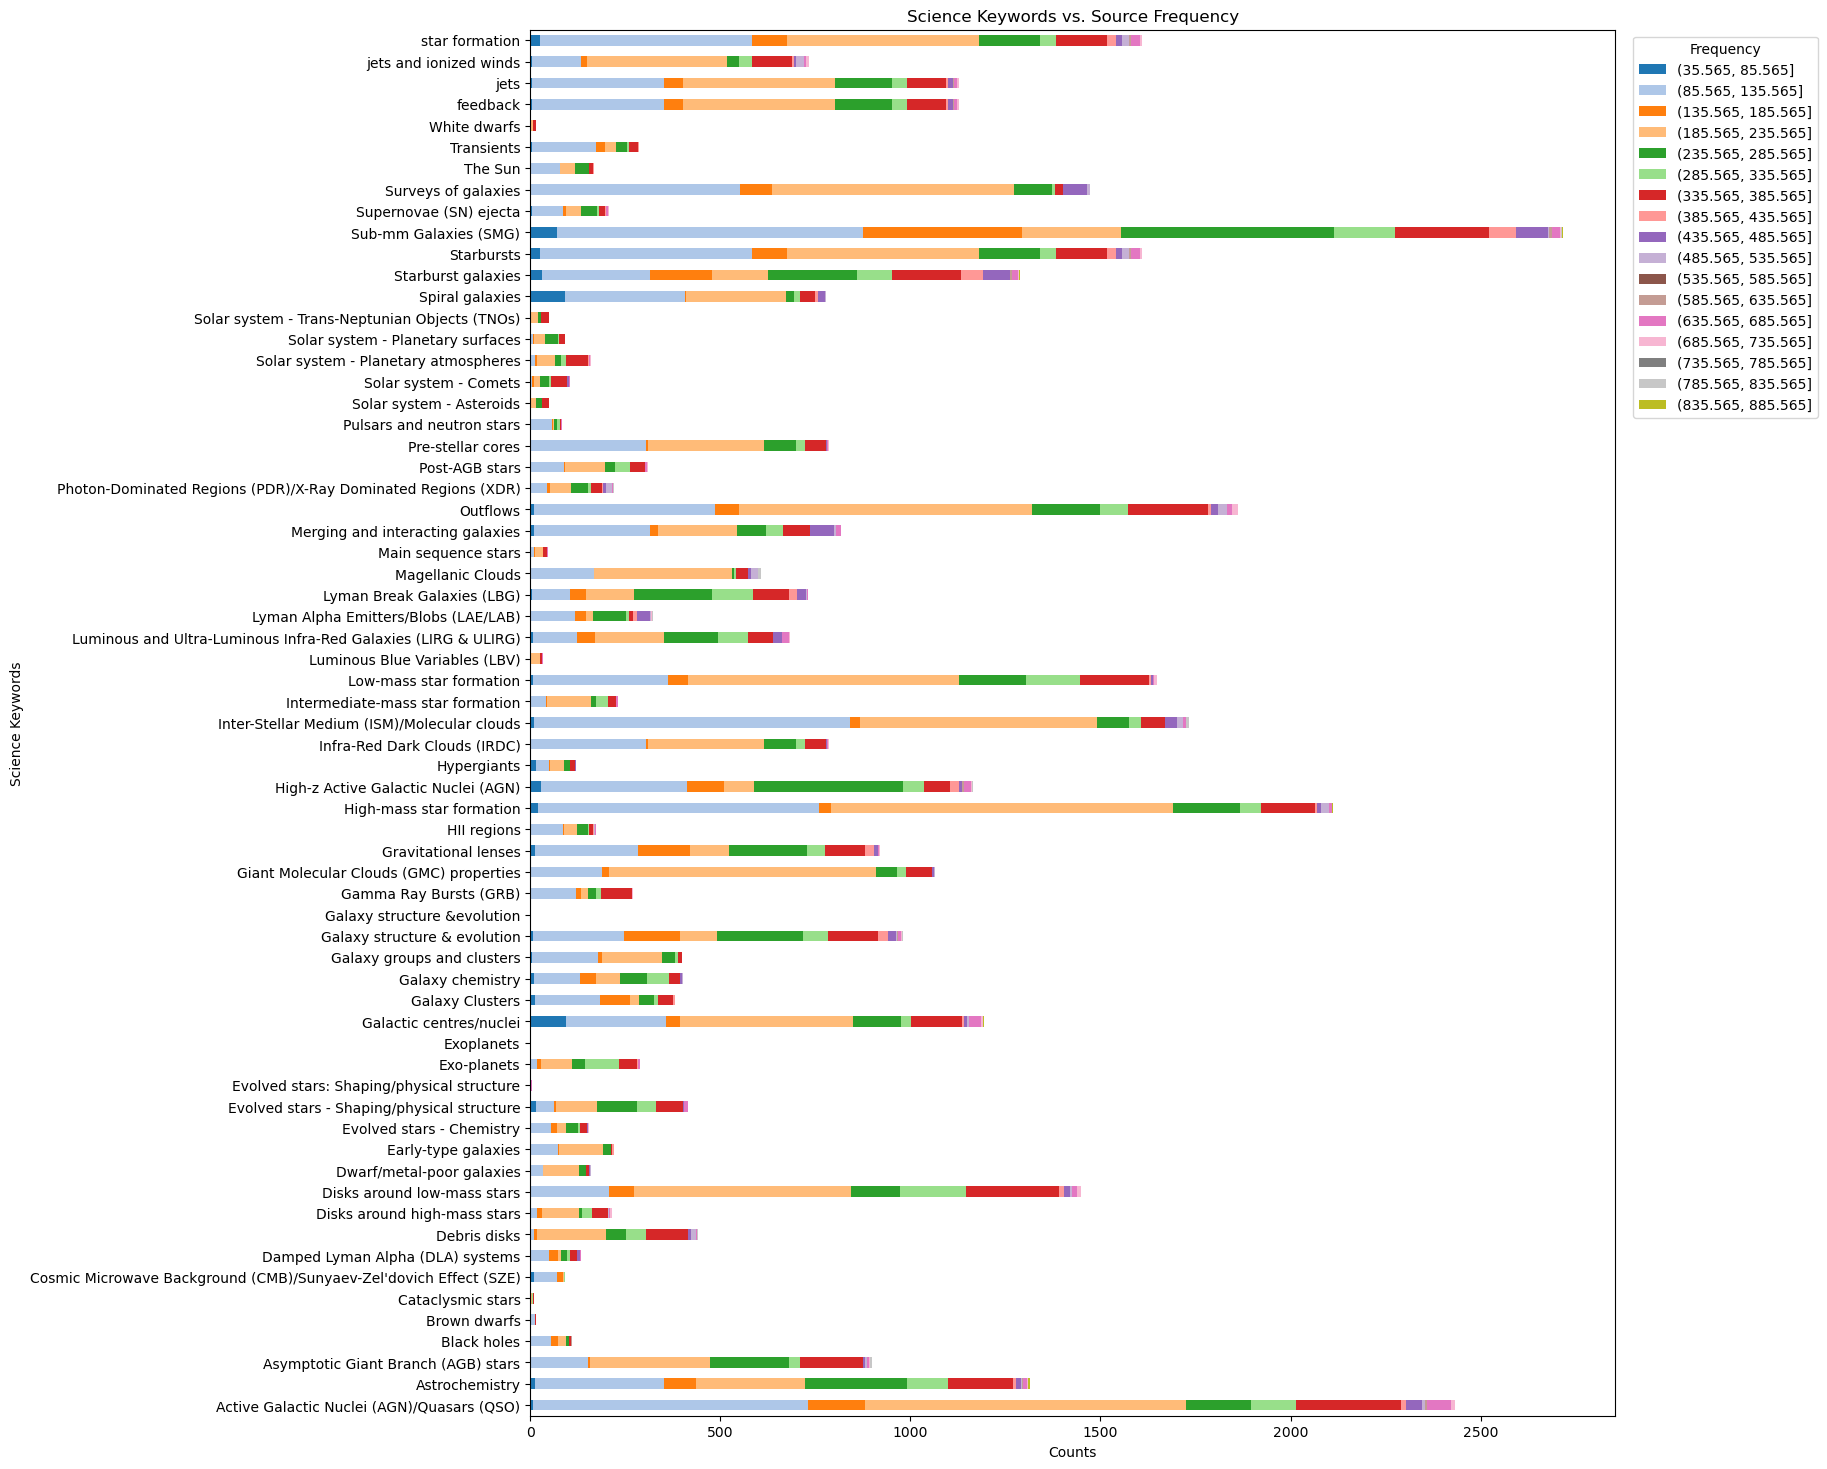

In [26]:
from astropy.constants import c
import astropy.units as U
import math
import pyvo
import numpy as np 
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt
import seaborn as sns

parent_dir=os.path.dirname(os.getcwd())

service_url = "https://almascience.eso.org/tap"
service = pyvo.dal.TAPService(service_url)
def count_science_keywords_with_bands(service):
    query = """  
            SELECT science_keyword, band_list, member_ous_uid, frequency, t_exptime
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    db = db.drop_duplicates(subset='member_ous_uid')
    db = db.drop(db[db['science_keyword'] == ''].index)
    # Splitting the science keywords at commas
    db['science_keyword'] = db['science_keyword'].str.split(',')
    # Exploding to have one row for each combination of science keyword and band
    db = db.explode('science_keyword')
    
    # Cleaning up science keywords and band names
    db['science_keyword'] = db['science_keyword'].str.strip()
    db['band_list'] = db['band_list'].str.split(' ')
    
    # Exploding to have one row for each combination of science keyword and band
    db = db.explode('band_list')
    db = db.explode('frequency')
    db = db.explode('t_exptime')
    # Cleaning up band names
    db['band_list'] = db['band_list'].str.strip()
    
    #Checking Freq. distribution
    plt.hist(db['frequency'], bins=50, alpha=0.75)
    plt.title('Frequency Distribution')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count')
    plt.show()

    #Checking time integration distribution < 30000 s 
    plt.hist(db['t_exptime'][db['t_exptime'] <= 30000], bins=100, alpha=0.75, log=True)
    plt.title('Integration Time Distribution')
    plt.xlabel('Integration Time (s)')
    plt.ylabel('Count')
    plt.xscale('log')
    plt.show()

    db = db[db['t_exptime'] <= 3e4]

    frequency_bins = np.arange(db['frequency'].min(), db['frequency'].max(), 50)  # 50 GHz bins
    db['frequency_bin'] = pd.cut(db['frequency'], bins=frequency_bins)
    time_bins = np.arange(db['t_exptime'].min(), db['t_exptime'].max(), 1000)  # 1000 second bins
    db['time_bin'] = pd.cut(db['t_exptime'], bins=time_bins)
    # Counting occurrences of each combination of science keyword and band
    db_sk_b = db.groupby(['science_keyword', 'band_list']).size().unstack(fill_value=0)
    db_sk_f = db.groupby(['science_keyword', 'frequency_bin']).size().unstack(fill_value=0)
    db_sk_t = db.groupby(['science_keyword', 'time_bin']).size().unstack(fill_value=0)
    
    return db_sk_b, db_sk_f, db_sk_t


service_url = "https://almascience.eso.org/tap"
service = pyvo.dal.TAPService(service_url)
    
# Count science keywords with bands
db_sk_b, db_sk_f, db_sk_t = count_science_keywords_with_bands(service)

custom_palette = sns.color_palette("tab20")
sns.set_palette(custom_palette)

print("Counts of Science Keywords with ALMA Bands:")
print(db_sk_b)
plt.rcParams["figure.figsize"] = (14,18)
db_sk_b.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. ALMA Bands')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='ALMA Bands')
plt.show()  
 
print("Counts of Science Keywords with Integration Time:")
print(db_sk_t)
plt.rcParams["figure.figsize"] = (14,18)
db_sk_t.plot(kind='barh', stacked=True)
plt.title('Science Keywords vs. Integration Time')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(title='Integration Time', loc='upper left', bbox_to_anchor=(1.01, 1))
plt.show()

plt.rcParams["figure.figsize"] = (14,18)
db_sk_f.plot(kind='barh', stacked=True, color=custom_palette)
plt.title('Science Keywords vs. Source Frequency')
plt.xlabel('Counts')
plt.ylabel('Science Keywords')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left',title='Frequency')
plt.show()  


In [27]:
pd.set_option('display.max.rows', None)
pd.set_option('display.max.columns', None)
db_sk_b

band_list,1,10,3,4,5,6,7,8,9
science_keyword,,,,,,,,,
Active Galactic Nuclei (AGN)/Quasars (QSO),1,1,694,123,88,978,406,65,77
Astrochemistry,1,5,344,78,38,506,302,25,15
Asymptotic Giant Branch (AGB) stars,0,11,135,22,1,519,198,11,8
Black holes,2,0,52,18,0,28,8,0,3
Brown dwarfs,0,0,12,0,0,1,2,0,0
Cataclysmic stars,0,0,1,2,0,3,5,0,0
Cosmic Microwave Background (CMB)/Sunyaev-Zel'dovich Effect (SZE),5,0,61,20,0,4,1,0,0
Damped Lyman Alpha (DLA) systems,0,0,40,32,6,17,27,9,2
Debris disks,0,1,10,4,10,227,165,21,3
